In [29]:
# Setup: Add project root to path and import utilities
import sys
sys.path.insert(0, '..')

from utils import get_input

# Load input data for day 11
data = get_input(11, example=False)

print(f"Loaded {len(data)} lines of input")
print("Sample data:")
for line in data[:5]:
    print(f"  {line}")

Loaded 583 lines of input
Sample data:
  zzt: ujd
  xmi: qra znx lif phy sam
  jgi: owt yna
  prb: dlh ywv
  mlq: klk jjy gcg


In [30]:
# Define a directed path based on data
# example line: bbb: ddd eee
# everything before the : is the node
# everything after the : are the directed edges to other nodes

from networkx import DiGraph
from networkx import all_simple_paths
import networkx as nx

def build_graph(data: list[str]) -> DiGraph:
    graph = DiGraph()
    for line in data:
        node, edges_str = line.split(':')
        edges = edges_str.strip().split() if edges_str.strip() else []
        for edge in edges:
            graph.add_edge(node, edge)
    return graph

In [31]:
graph = build_graph(data)
print(f"Graph has {graph.number_of_nodes()} nodes and {graph.number_of_edges()} edges.")

Graph has 584 nodes and 1725 edges.


In [40]:
# Alternative: Use topological layers to segment the graph
# Since it's a DAG, we can organize nodes by their topological order

def get_topological_layers(graph: DiGraph, source: str, target: str) -> dict[int, set[str]]:
    """
    Group nodes into layers based on topological ordering.
    Layer number = maximum distance from source over ALL paths (not just shortest).
    Only includes nodes that are on some path from source to target.
    """
    # Get nodes on any path from source to target
    reachable_from_source = nx.descendants(graph, source) | {source}
    can_reach_target = nx.ancestors(graph, target) | {target}
    relevant_nodes = reachable_from_source & can_reach_target
    
    # Calculate MAXIMUM path length from source to each node
    # This ensures proper topological ordering for path counting
    layers = {}
    max_distance = {source: 0}
    
    # Process nodes in topological order
    for node in nx.topological_sort(graph):
        if node not in relevant_nodes:
            continue
            
        if node == source:
            distance = 0
        else:
            # Maximum distance = 1 + max distance of any predecessor
            distance = 0
            for predecessor in graph.predecessors(node):
                if predecessor in max_distance:
                    distance = max(distance, max_distance[predecessor] + 1)
        
        max_distance[node] = distance
        
        if distance not in layers:
            layers[distance] = set()
        layers[distance].add(node)
    
    return layers


In [33]:
# Count paths using dynamic programming on layers
def count_paths_by_layers(graph: DiGraph, source: str, target: str) -> int:
    """
    Count all simple paths from source to target using layer-by-layer DP.
    Works efficiently on DAGs by processing nodes in topological order.
    """
    # Get topological layers
    layers = get_topological_layers(graph, source, target)
    
    # Initialize path counts: paths[node] = number of ways to reach node from source
    path_counts = {source: 1}
    
    # Process layers in order
    for layer_num in sorted(layers.keys()):
        for node in layers[layer_num]:
            if node == source:
                continue
            
            # Count paths to this node from all predecessors
            count = 0
            for predecessor in graph.predecessors(node):
                if predecessor in path_counts:
                    count += path_counts[predecessor]
            
            path_counts[node] = count
    
    return path_counts.get(target, 0)

In [34]:
# Count paths through required nodes using multiplication
def count_paths_through_nodes(graph: DiGraph, source: str, target: str, required_nodes: list[str]) -> int:
    """
    Count paths from source to target that pass through all required nodes.
    Uses multiplication: if we must go A → B → C, count paths as:
    (paths from A to B) × (paths from B to C)
    """
    if not required_nodes:
        return count_paths_by_layers(graph, source, target)
    
    # Create the sequence of waypoints: source → req1 → req2 → ... → target
    waypoints = [source] + required_nodes + [target]
    
    # Calculate path count for each segment and multiply
    total_count = 1
    for i in range(len(waypoints) - 1):
        segment_start = waypoints[i]
        segment_end = waypoints[i + 1]
        
        segment_count = count_paths_by_layers(graph, segment_start, segment_end)
        print(f"  Segment '{segment_start}' → '{segment_end}': {segment_count:,} paths")
        
        if segment_count == 0:
            return 0  # No valid paths if any segment is unreachable
        
        total_count *= segment_count
    
    return total_count

In [41]:
# Apply to the specific orderings requested
print("\n=== Specific Path Orderings ===")

cases = [
    ('svr', 'out', ['fft', 'dac']),
    ('svr', 'out', ['dac', 'fft']),
]

for start, end, required in cases:
    print(f"\nPaths from '{start}' to '{end}' through {required} (in order):")
    count = count_paths_through_nodes(graph, start, end, required)
    print(f"Total: {count:,}")


=== Specific Path Orderings ===

Paths from 'svr' to 'out' through ['fft', 'dac'] (in order):
  Segment 'svr' → 'fft': 9,143 paths
  Segment 'fft' → 'dac': 6,374,170 paths
  Segment 'dac' → 'out': 7,935 paths
Total: 462,444,153,119,850

Paths from 'svr' to 'out' through ['dac', 'fft'] (in order):
  Segment 'svr' → 'dac': 920,502,135,214 paths
  Segment 'dac' → 'fft': 0 paths
Total: 0


In [36]:
start_node = 'svr'
end_node = 'out'

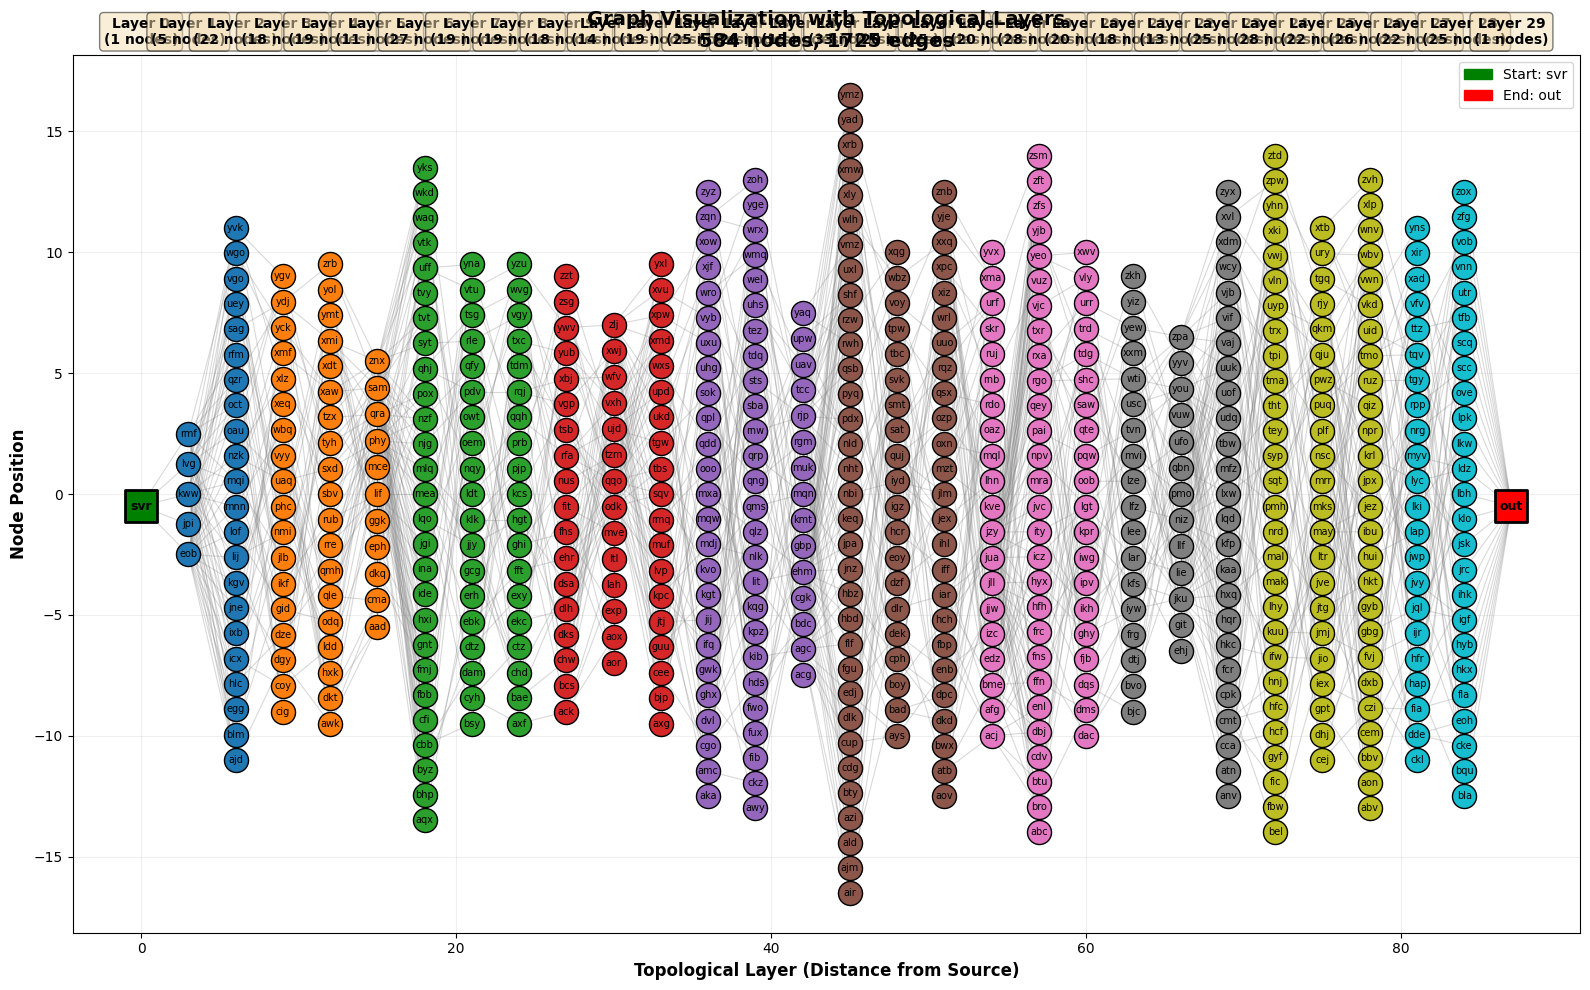


=== Layer Statistics ===
Layer 0: 1 nodes - ['svr']
Layer 1: 5 nodes - ['eob', 'jpi', 'kww', 'lvg', 'rmf']
Layer 2: 22 nodes - ['ajd', 'blm', 'egg', 'hlc', 'icx', 'ixb', 'jne', 'kgv', 'lij', 'lof', 'mnn', 'mqi', 'nzk', 'oau', 'oct', 'qzr', 'rfm', 'sag', 'uey', 'vgo', 'wgo', 'yvk']
Layer 3: 18 nodes - ['cig', 'coy', 'dgy', 'dze', 'gid', 'ikf', 'jlb', 'nmi', 'phc', 'uaq', 'vyy', 'wbq', 'xeq', 'xlz', 'xmf', 'yck', 'ydj', 'ygv']
Layer 4: 19 nodes - ['awk', 'dkt', 'hxk', 'ldd', 'odq', 'qle', 'qmh', 'rre', 'rub', 'sbv', 'sxd', 'tyh', 'tzx', 'xaw', 'xdt', 'xmi', 'ymt', 'yol', 'zrb']
Layer 5: 11 nodes - ['aad', 'cma', 'dkq', 'eph', 'ggk', 'lif', 'mce', 'phy', 'qra', 'sam', 'znx']
Layer 6: 27 nodes - ['aqx', 'bhp', 'byz', 'cbb', 'cfi', 'fbb', 'fmj', 'gnt', 'hxi', 'ide', 'ina', 'jgi', 'lqo', 'mea', 'mlq', 'njg', 'nzf', 'pox', 'qhj', 'syt', 'tvt', 'tvy', 'uff', 'vtk', 'waq', 'wkd', 'yks']
Layer 7: 19 nodes - ['bsy', 'cyh', 'dam', 'dtz', 'ebk', 'erh', 'gcg', 'jjy', 'klk', 'ldt', 'nqy', 'oem', 'ow

In [37]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
import numpy as np

# Get topological layers for visualization
layers = get_topological_layers(graph, start_node, end_node)

# Create a layered layout
pos = {}
layer_colors = {}
color_palette = plt.cm.tab10(np.linspace(0, 1, len(layers)))

for layer_num, nodes in sorted(layers.items()):
    nodes_list = sorted(list(nodes))
    num_nodes = len(nodes_list)
    
    # Spread nodes vertically within their layer
    y_positions = np.linspace(-num_nodes/2, num_nodes/2, num_nodes)
    
    for i, node in enumerate(nodes_list):
        pos[node] = (layer_num * 3, y_positions[i])
        layer_colors[node] = color_palette[layer_num]

# Create figure
fig, ax = plt.subplots(figsize=(16, 10))

# Draw edges first (so they appear behind nodes)
edge_x = []
edge_y = []
for source, target in graph.edges():
    if source in pos and target in pos:
        x0, y0 = pos[source]
        x1, y1 = pos[target]
        ax.plot([x0, x1], [y0, y1], 'gray', alpha=0.3, linewidth=0.8, zorder=1)

# Draw nodes colored by layer
for node, (x, y) in pos.items():
    color = layer_colors[node]
    
    # Highlight start and end nodes
    if node == start_node:
        ax.scatter(x, y, s=500, c='green', edgecolors='black', linewidths=2, zorder=3, marker='s')
        ax.text(x, y, node, ha='center', va='center', fontsize=9, fontweight='bold', zorder=4)
    elif node == end_node:
        ax.scatter(x, y, s=500, c='red', edgecolors='black', linewidths=2, zorder=3, marker='s')
        ax.text(x, y, node, ha='center', va='center', fontsize=9, fontweight='bold', zorder=4)
    else:
        ax.scatter(x, y, s=300, c=[color], edgecolors='black', linewidths=1, zorder=2)
        ax.text(x, y, node, ha='center', va='center', fontsize=7, zorder=4)

# Add layer labels
for layer_num in sorted(layers.keys()):
    layer_x = layer_num * 3
    ax.text(layer_x, max(y for x, y in pos.values()) + 2, 
            f'Layer {layer_num}\n({len(layers[layer_num])} nodes)', 
            ha='center', va='bottom', fontsize=10, fontweight='bold',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

ax.set_xlabel('Topological Layer (Distance from Source)', fontsize=12, fontweight='bold')
ax.set_ylabel('Node Position', fontsize=12, fontweight='bold')
ax.set_title(f'Graph Visualization with Topological Layers\n{graph.number_of_nodes()} nodes, {graph.number_of_edges()} edges', 
             fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.2)
ax.set_axisbelow(True)

# Create legend
legend_elements = [
    mpatches.Patch(color='green', label=f'Start: {start_node}'),
    mpatches.Patch(color='red', label=f'End: {end_node}'),
]
ax.legend(handles=legend_elements, loc='upper right', fontsize=10)

plt.tight_layout()
plt.show()

# Print layer statistics
print("\n=== Layer Statistics ===")
for layer_num in sorted(layers.keys()):
    nodes = layers[layer_num]
    print(f"Layer {layer_num}: {len(nodes)} nodes - {sorted(list(nodes))}")

In [38]:
# Alternative: Use plotly for interactive visualization
import plotly.graph_objects as go

# Prepare edge traces
edge_traces = []
for source, target in graph.edges():
    if source in pos and target in pos:
        x0, y0 = pos[source]
        x1, y1 = pos[target]
        edge_traces.append(
            go.Scatter(
                x=[x0, x1, None],
                y=[y0, y1, None],
                mode='lines',
                line=dict(color='rgba(125, 125, 125, 0.3)', width=1),
                hoverinfo='none',
                showlegend=False
            )
        )

# Prepare node traces by layer
node_traces = []
for layer_num in sorted(layers.keys()):
    nodes_list = sorted(list(layers[layer_num]))
    
    x_coords = [pos[node][0] for node in nodes_list]
    y_coords = [pos[node][1] for node in nodes_list]
    
    # Count incoming paths to each node for sizing
    node_sizes = []
    for node in nodes_list:
        if node == start_node:
            size = 30
        elif node == end_node:
            size = 30
        else:
            # Size by number of predecessors
            size = 15 + len(list(graph.predecessors(node))) * 2
        node_sizes.append(size)
    
    # Create hover text with path information
    hover_texts = []
    for node in nodes_list:
        in_degree = graph.in_degree(node)
        out_degree = graph.out_degree(node)
        predecessors = list(graph.predecessors(node))
        successors = list(graph.successors(node))
        
        hover_text = f"<b>{node}</b><br>"
        hover_text += f"Layer: {layer_num}<br>"
        hover_text += f"In-degree: {in_degree}<br>"
        hover_text += f"Out-degree: {out_degree}<br>"
        if predecessors:
            hover_text += f"From: {', '.join(sorted(predecessors)[:5])}"
            if len(predecessors) > 5:
                hover_text += f"... (+{len(predecessors)-5} more)"
            hover_text += "<br>"
        if successors:
            hover_text += f"To: {', '.join(sorted(successors)[:5])}"
            if len(successors) > 5:
                hover_text += f"... (+{len(successors)-5} more)"
        
        hover_texts.append(hover_text)
    
    # Determine color
    if start_node in nodes_list:
        color = 'green'
        name = f'Layer {layer_num} (START)'
    elif end_node in nodes_list:
        color = 'red'
        name = f'Layer {layer_num} (END)'
    else:
        color = color_palette[layer_num]
        name = f'Layer {layer_num}'
    
    node_traces.append(
        go.Scatter(
            x=x_coords,
            y=y_coords,
            mode='markers+text',
            marker=dict(
                size=node_sizes,
                color=[f'rgba({int(color[0]*255)},{int(color[1]*255)},{int(color[2]*255)},0.8)' 
                       if isinstance(color, (list, tuple, np.ndarray)) else color 
                       for _ in nodes_list],
                line=dict(color='black', width=1)
            ),
            text=nodes_list,
            textposition='middle center',
            textfont=dict(size=8, color='white'),
            hovertext=hover_texts,
            hoverinfo='text',
            name=name
        )
    )

# Create figure
fig = go.Figure(data=edge_traces + node_traces)

fig.update_layout(
    title=dict(
        text=f'Interactive Graph Visualization<br>Path from {start_node} to {end_node}<br>'
             f'{graph.number_of_nodes()} nodes, {graph.number_of_edges()} edges',
        x=0.5,
        xanchor='center'
    ),
    showlegend=True,
    hovermode='closest',
    margin=dict(b=20, l=5, r=5, t=100),
    xaxis=dict(
        title='Topological Layer',
        showgrid=True,
        zeroline=False,
        showticklabels=True
    ),
    yaxis=dict(
        title='Node Position',
        showgrid=True,
        zeroline=False,
        showticklabels=True
    ),
    width=1200,
    height=800,
    plot_bgcolor='rgba(240, 240, 240, 0.5)'
)

fig.show()

print(f"\n💡 Hover over nodes to see detailed connection information!")
print(f"📊 Node sizes reflect the number of incoming connections")


💡 Hover over nodes to see detailed connection information!
📊 Node sizes reflect the number of incoming connections


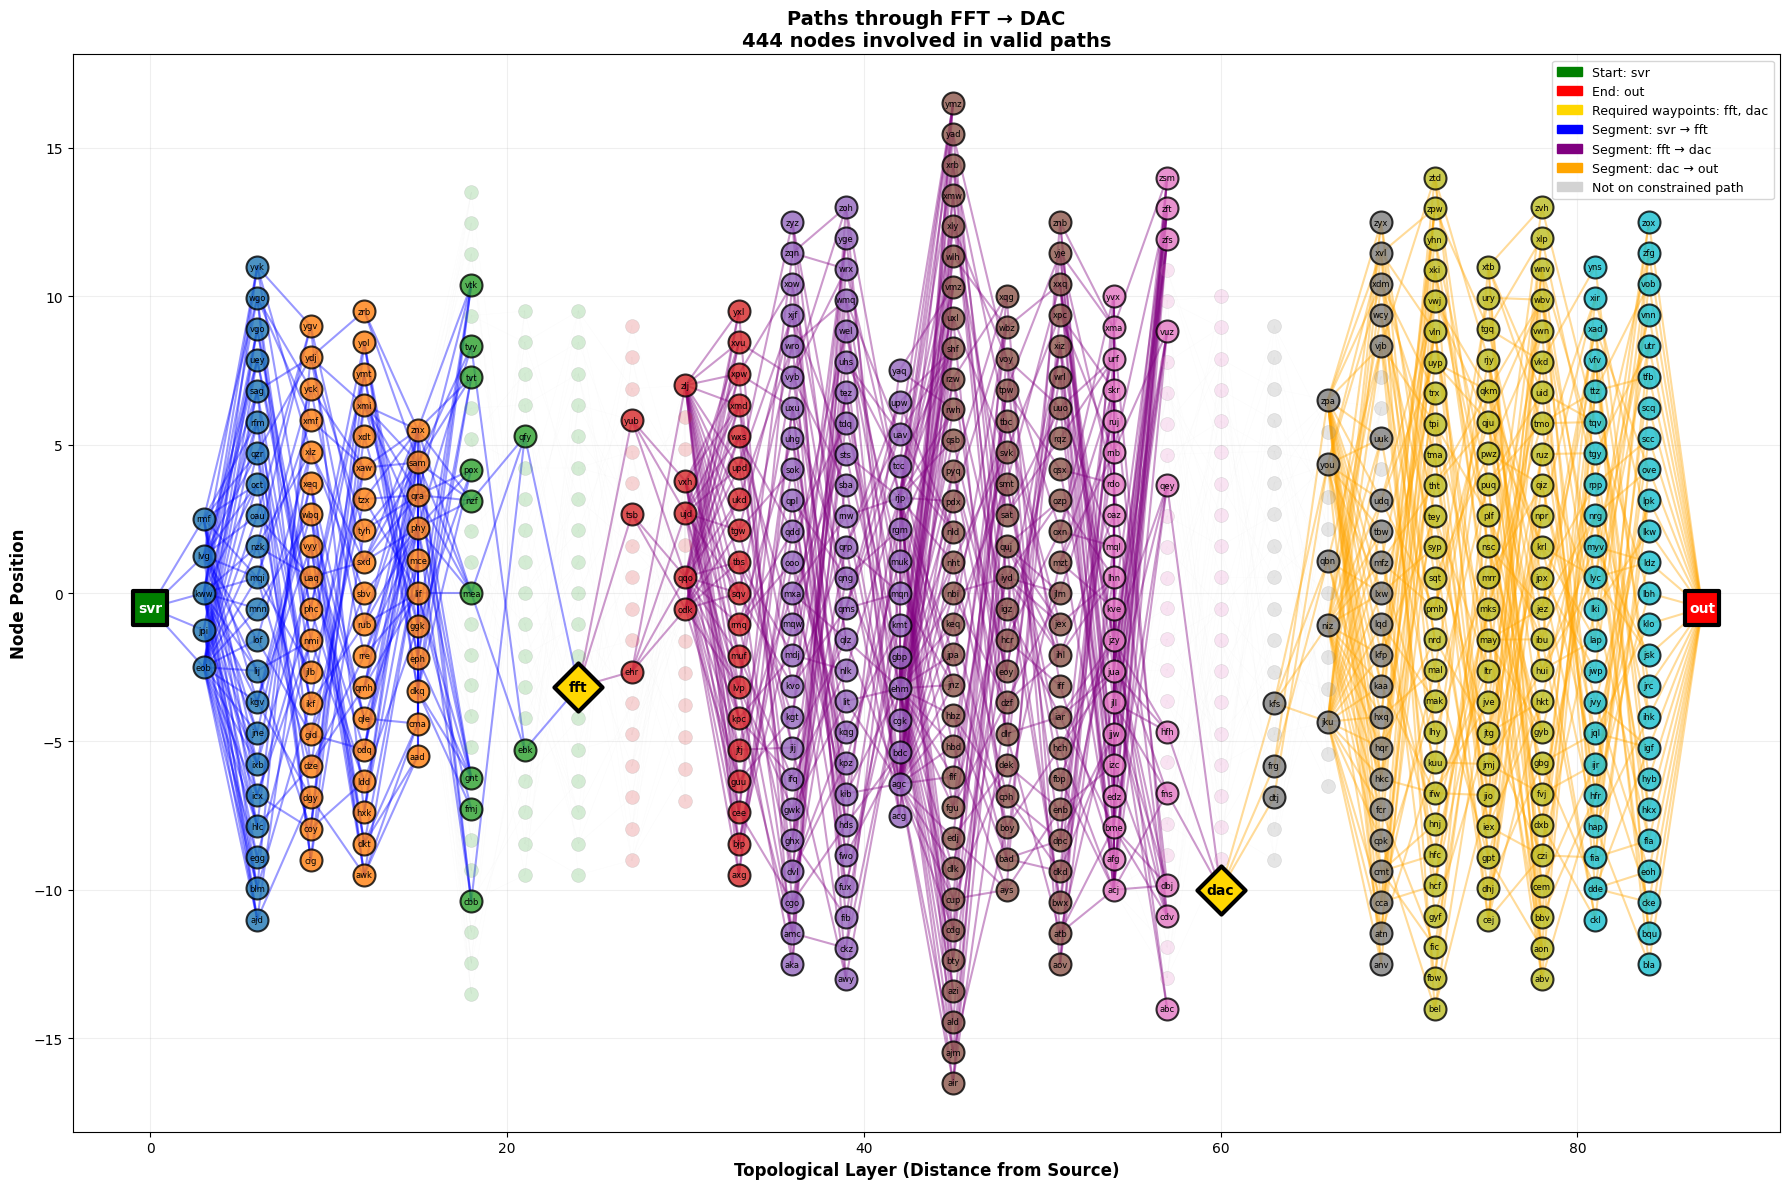


=== Path Statistics ===
Total nodes in graph: 584
Nodes involved in paths through fft→dac: 444
Percentage of graph used: 76.0%

Segment svr → fft:
  Nodes involved: 88
  Number of paths: 3,148

Segment fft → dac:
  Nodes involved: 203
  Number of paths: 277,858

Segment dac → out:
  Nodes involved: 155
  Number of paths: 7,935


In [39]:
# Visualize paths through specific nodes (fft -> dac)
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

# Define the required waypoints
waypoint_nodes = ['fft', 'dac']

# Get all relevant nodes for each segment
def get_nodes_on_paths(graph, source, target):
    """Get all nodes that lie on at least one path from source to target"""
    reachable_from_source = nx.descendants(graph, source) | {source}
    can_reach_target = nx.ancestors(graph, target) | {target}
    return reachable_from_source & can_reach_target

# Calculate which nodes are on paths through the waypoints
waypoints = [start_node] + waypoint_nodes + [end_node]
all_relevant_nodes = set()

for i in range(len(waypoints) - 1):
    segment_nodes = get_nodes_on_paths(graph, waypoints[i], waypoints[i + 1])
    all_relevant_nodes.update(segment_nodes)

# Create visualization
fig, ax = plt.subplots(figsize=(18, 12))

# Draw all edges in light gray first
for source, target in graph.edges():
    if source in pos and target in pos:
        x0, y0 = pos[source]
        x1, y1 = pos[target]
        
        # Check if this edge is on a relevant path
        if source in all_relevant_nodes and target in all_relevant_nodes:
            # Could be on the path - draw in color based on segment
            segment_idx = None
            for i in range(len(waypoints) - 1):
                segment_nodes = get_nodes_on_paths(graph, waypoints[i], waypoints[i + 1])
                if source in segment_nodes and target in segment_nodes:
                    segment_idx = i
                    break
            
            if segment_idx == 0:  # svr -> fft
                ax.plot([x0, x1], [y0, y1], color='blue', alpha=0.4, linewidth=1.5, zorder=1)
            elif segment_idx == 1:  # fft -> dac
                ax.plot([x0, x1], [y0, y1], color='purple', alpha=0.4, linewidth=1.5, zorder=1)
            elif segment_idx == 2:  # dac -> out
                ax.plot([x0, x1], [y0, y1], color='orange', alpha=0.4, linewidth=1.5, zorder=1)
            else:
                ax.plot([x0, x1], [y0, y1], 'lightgray', alpha=0.2, linewidth=0.5, zorder=0)
        else:
            # Not on relevant path
            ax.plot([x0, x1], [y0, y1], 'lightgray', alpha=0.1, linewidth=0.3, zorder=0)

# Draw nodes
for node, (x, y) in pos.items():
    if node == start_node:
        ax.scatter(x, y, s=600, c='green', edgecolors='black', linewidths=3, zorder=4, marker='s')
        ax.text(x, y, node, ha='center', va='center', fontsize=10, fontweight='bold', zorder=5, color='white')
    elif node == end_node:
        ax.scatter(x, y, s=600, c='red', edgecolors='black', linewidths=3, zorder=4, marker='s')
        ax.text(x, y, node, ha='center', va='center', fontsize=10, fontweight='bold', zorder=5, color='white')
    elif node in waypoint_nodes:
        ax.scatter(x, y, s=600, c='gold', edgecolors='black', linewidths=3, zorder=4, marker='D')
        ax.text(x, y, node, ha='center', va='center', fontsize=10, fontweight='bold', zorder=5)
    elif node in all_relevant_nodes:
        # Node on the path - color by layer but more prominent
        color = layer_colors[node]
        ax.scatter(x, y, s=250, c=[color], edgecolors='black', linewidths=1.5, zorder=2, alpha=0.8)
        ax.text(x, y, node, ha='center', va='center', fontsize=6, zorder=3)
    else:
        # Node not on path - very faded
        color = layer_colors[node]
        ax.scatter(x, y, s=100, c=[color], edgecolors='gray', linewidths=0.5, zorder=1, alpha=0.2)

# Add title and labels
ax.set_xlabel('Topological Layer (Distance from Source)', fontsize=12, fontweight='bold')
ax.set_ylabel('Node Position', fontsize=12, fontweight='bold')
ax.set_title(f'Paths through FFT → DAC\n{len(all_relevant_nodes)} nodes involved in valid paths', 
             fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.2)
ax.set_axisbelow(True)

# Create legend
legend_elements = [
    mpatches.Patch(color='green', label=f'Start: {start_node}'),
    mpatches.Patch(color='red', label=f'End: {end_node}'),
    mpatches.Patch(color='gold', label='Required waypoints: fft, dac'),
    mpatches.Patch(color='blue', label='Segment: svr → fft'),
    mpatches.Patch(color='purple', label='Segment: fft → dac'),
    mpatches.Patch(color='orange', label='Segment: dac → out'),
    mpatches.Patch(color='lightgray', label='Not on constrained path'),
]
ax.legend(handles=legend_elements, loc='upper right', fontsize=9)

plt.tight_layout()
plt.show()

# Print statistics
print(f"\n=== Path Statistics ===")
print(f"Total nodes in graph: {graph.number_of_nodes()}")
print(f"Nodes involved in paths through fft→dac: {len(all_relevant_nodes)}")
print(f"Percentage of graph used: {100*len(all_relevant_nodes)/graph.number_of_nodes():.1f}%")

# Show segment breakdown
for i in range(len(waypoints) - 1):
    segment_nodes = get_nodes_on_paths(graph, waypoints[i], waypoints[i + 1])
    segment_count = count_paths_by_layers(graph, waypoints[i], waypoints[i + 1])
    print(f"\nSegment {waypoints[i]} → {waypoints[i+1]}:")
    print(f"  Nodes involved: {len(segment_nodes)}")
    print(f"  Number of paths: {segment_count:,}")